In [37]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from IPython.display import display


In [38]:
df = pd.read_csv('../data/yield_final.csv')

In [39]:
categorical = ['country','crop', 'year']
numerical = ['average_rain_fall_mm_per_year',
 'pesticide_tonnes',
 'avg_temp']
final_metrics = []

In [40]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [41]:
df_train=df_train.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)
df_val=df_val.reset_index(drop=True)

y_train = df_train.yield_hg_ha.values
y_test = df_test.yield_hg_ha.values
y_val = df_val.yield_hg_ha.values

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

del df_train['yield_hg_ha']
del df_test['yield_hg_ha']
del df_val['yield_hg_ha']

# Linear Regression

In [42]:
# Log-transform highly skewed numerical features
skewed_features = ['pesticide_tonnes', 'average_rain_fall_mm_per_year']
for col in skewed_features:
    df_train[col] = np.log1p(df_train[col])
    df_val[col] = np.log1p(df_val[col])
    df_test[col] = np.log1p(df_test[col])

In [43]:
scaler = StandardScaler()
df_train[numerical] = scaler.fit_transform(df_train[numerical])
df_val[numerical] = scaler.transform(df_val[numerical])
df_test[numerical] = scaler.transform(df_test[numerical])


In [44]:
def train(df_train, y_train):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    #feature_names = dv.get_feature_names_out()
    
    #print(feature_names)
    
    model = LinearRegression()
    model.fit(X_train, y_train)

    return dv, model


def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict(X)

    return y_pred

def regression_metrics(y_actual, y_pred):
    mse = mean_squared_error(y_actual, y_pred)  # compare with y_val in original units
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)

    return rmse, mae, r2

## Results

In [45]:
# Train the model
dv, model = train(df_train, y_train_log)

# Predict on validation/test set
y_pred_val_log = predict(df_val, dv, model)  # predictions in log scale
y_pred_val = np.expm1(y_pred_val_log)        # convert back to original units

y_pred_test_log = predict(df_test, dv, model)
y_pred_test = np.expm1(y_pred_test_log)

# Evaluate on validation set (original units)
rmse, mae, r2 = regression_metrics(y_val, y_pred_val)

print("Validation RMSE:", rmse)
print("MAE:", mae)
print("Validation R2:", r2)

final_metrics.append(('Linear Regression', rmse, mae, r2))

Validation RMSE: 37364.657196581524
MAE: 21836.710189452457
Validation R2: 0.7867100068473064


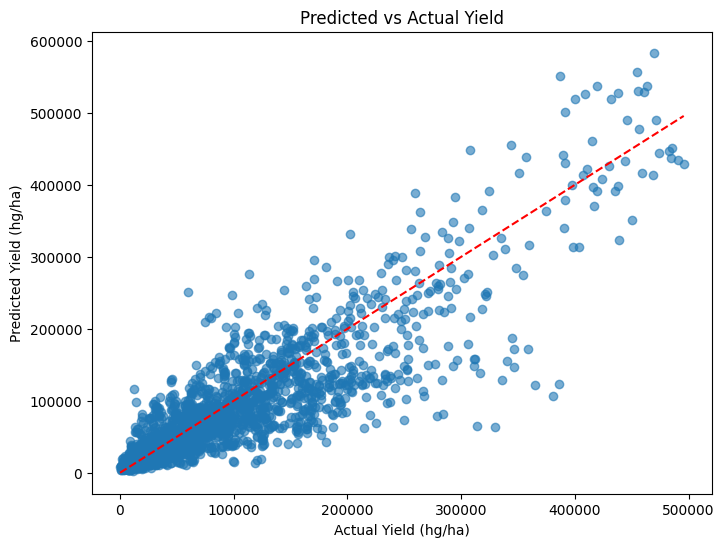

In [46]:
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred_val, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # perfect prediction line
plt.xlabel("Actual Yield (hg/ha)")
plt.ylabel("Predicted Yield (hg/ha)")
plt.title("Predicted vs Actual Yield")
plt.show()

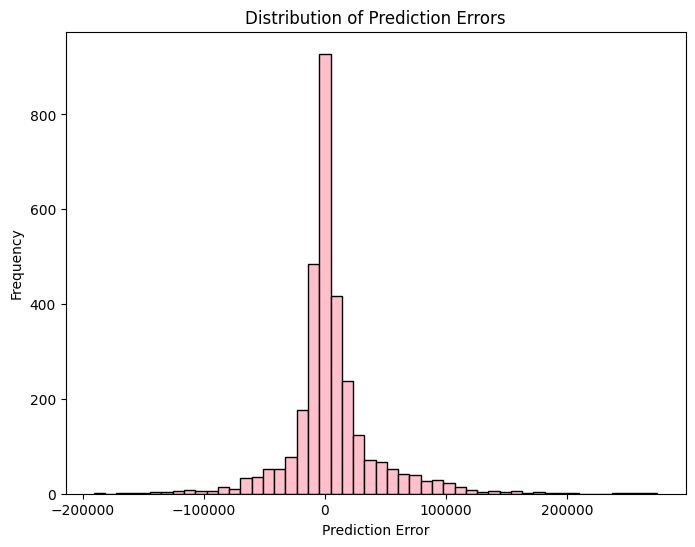

In [47]:
plt.figure(figsize=(8,6))
plt.hist(y_val - y_pred_val, bins=50, color='pink', edgecolor='k')
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()


# Random Forest

In [48]:
# Train Random Forest Regressor
def rf_train(df_train, y_train, n_estimators, max_depth, min_samples_leaf=5):
    dicts = df_train.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    rf = RandomForestRegressor(n_estimators=n_estimators, 
                               max_depth=max_depth, min_samples_leaf=min_samples_leaf, 
                               random_state=1)
    rf.fit(X_train, y_train)
    
    return dv, rf

# Predict function
def rf_predict(df, dv, rf):
    dicts = df.to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = rf.predict(X)
    return y_pred

In [49]:
# Train on log-transformed target

# Find best n_estimator and max_depth combination

n_estimators = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,100,200]

scores = [] 

for d in range(5,31,5):
    for n in n_estimators:
        dv, rf = rf_train(df_train, y_train_log, n_estimators=n, max_depth=d)
        
        # Predict on validation set
        y_pred_val_log = rf_predict(df_val, dv, rf)
        y_pred_val = np.expm1(y_pred_val_log)  # convert back to original units
        
        # Predict on test set
        y_pred_test_log = rf_predict(df_test, dv, rf)
        y_pred_test = np.expm1(y_pred_test_log)

        # Predict on train set - only to measure against val set. 
        y_pred_train_log = rf_predict(df_train, dv, rf)
        y_pred_train = np.expm1(y_pred_train_log)
        
        # Evaluate metrics on val
        rmse, mae, r2_val = regression_metrics(y_val, y_pred_val)
        
        r2_train = r2_score(y_train, y_pred_train)
        
        scores.append((d,n,rmse,mae,r2_val,r2_train))
    


In [50]:
columns = ['max_depth', 'n_estimators', 'rmse', 'mae', 'r2_val', 'r2_train']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores_pivot = df_scores.pivot(index='max_depth', columns=['n_estimators'], values=['r2_val'])

df_scores['r2_diff'] = df_scores['r2_train'] - df_scores['r2_val']


## Hyperparameter Tuning

### Choosing the best `max_depth` value

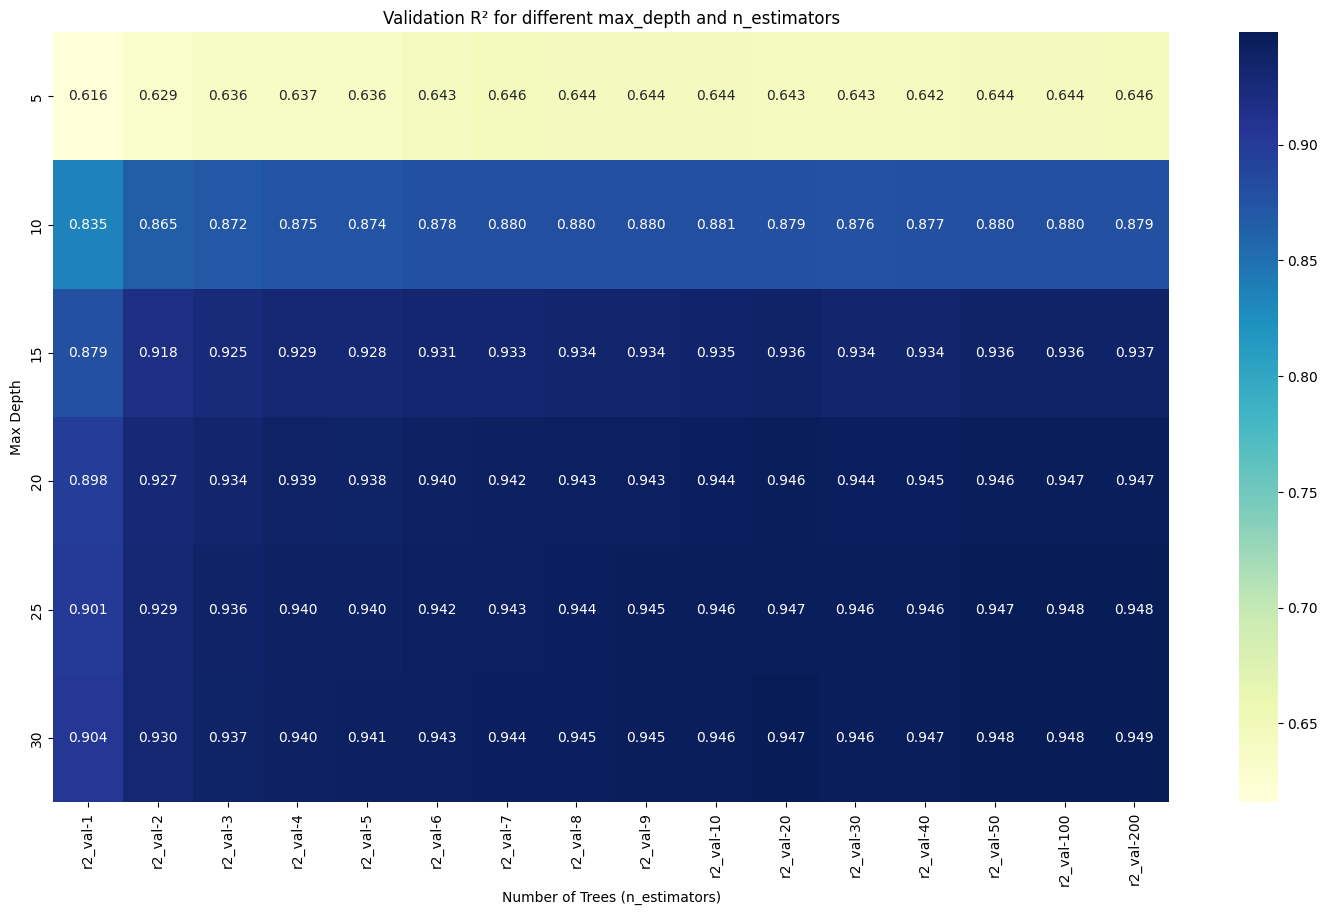

In [51]:
plt.figure(figsize=(18,10))
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f", cmap='YlGnBu')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Max Depth")
plt.title("Validation R² for different max_depth and n_estimators")
plt.show()

**Since, there's not a lot of difference in R2 values on increasing max_depth to more than 20, we will stick with `max_depth=20`**

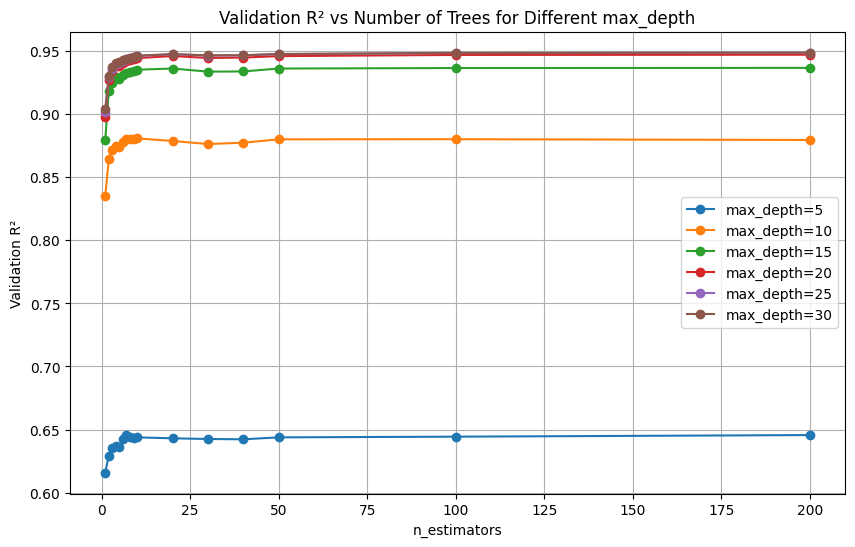

In [52]:
plt.figure(figsize=(10,6))

for depth in sorted(df_scores['max_depth'].unique()):
    subset = df_scores[df_scores['max_depth'] == depth]
    plt.plot(subset['n_estimators'], subset['r2_val'], marker='o', label=f'max_depth={depth}')

plt.xlabel('n_estimators')
plt.ylabel('Validation R²')
plt.title('Validation R² vs Number of Trees for Different max_depth')
plt.legend()
plt.grid(True)
plt.show()

**Insights:**

R2 corresponding to n_estimators peaks at 20, and stays the same thereafter.<br>
Therefore, the best is `n_estimators=20`

#### Overfitting Estimation (max_depth)

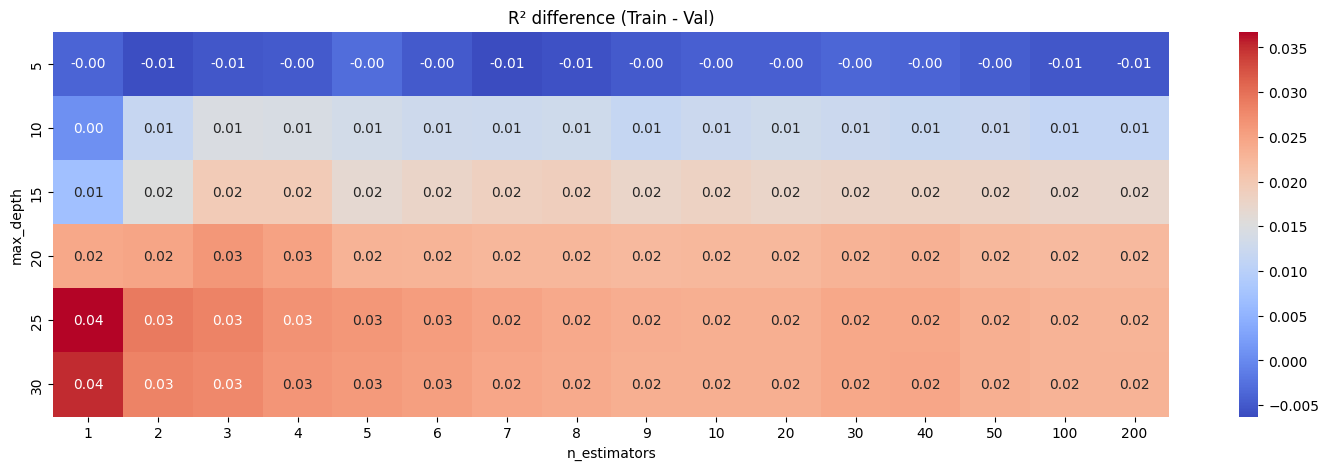

In [53]:
# Overfitting Estimation

pivot_val = df_scores.pivot(index='max_depth', columns='n_estimators', values='r2_val')
pivot_train = df_scores.pivot(index='max_depth', columns='n_estimators', values='r2_train')
pivot_diff = df_scores.pivot(index='max_depth', columns='n_estimators', values='r2_diff')

plt.figure(figsize=(18,5))

sns.heatmap(pivot_diff, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("R² difference (Train - Val)")

plt.show()

**Insights** : 

Since the difference in R2 between train and validation datasets are very small (max: 0.03), the `overfitting is negligible`

### Choosing the best `min_samples_leaf` value

In [54]:
min_leaf = [1,2,3,4,5,10,15,30,50]

scores = [] 
max_depth = 20 
n_estimators = 20

for s in min_leaf:
    dv, rf = rf_train(df_train, y_train_log, 
                      n_estimators=n_estimators, max_depth=max_depth, 
                      min_samples_leaf=s)
    
    # Predict on validation set
    y_pred_val_log = rf_predict(df_val, dv, rf)
    y_pred_val = np.expm1(y_pred_val_log)  # convert back to original units
    
    # Predict on test set
    y_pred_test_log = rf_predict(df_test, dv, rf)
    y_pred_test = np.expm1(y_pred_test_log)

    # Predict on train set - only to measure against val set. 
    y_pred_train_log = rf_predict(df_train, dv, rf)
    y_pred_train = np.expm1(y_pred_train_log)
    
    # Evaluate metrics on val
    rmse, mae, r2_val = regression_metrics(y_val, y_pred_val)
    
    r2_train = r2_score(y_train, y_pred_train)
    
    scores.append((s,rmse,mae,r2_val,r2_train))

In [55]:
columns = ['min_samples_leaf', 'rmse', 'mae', 'r2_val', 'r2_train']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores['r2_diff'] = df_scores['r2_train'] - df_scores['r2_val']


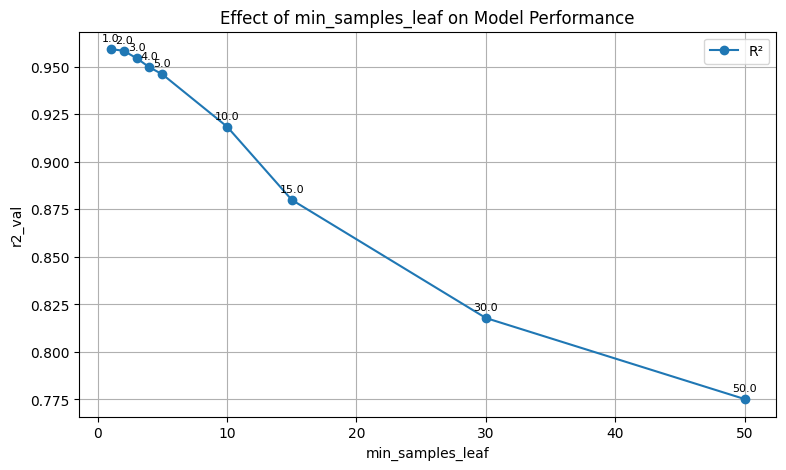

In [56]:
plt.figure(figsize=(9,5))
plt.plot(df_scores['min_samples_leaf'], df_scores['r2_val'], marker='o', label='R²')

for i, row in df_scores.iterrows():
    plt.text(row['min_samples_leaf'], row['r2_val']+0.003, 
             str(row['min_samples_leaf']), 
             fontsize=8, ha='center', va='bottom')

plt.xlabel('min_samples_leaf')
plt.ylabel('r2_val')
plt.title('Effect of min_samples_leaf on Model Performance')
plt.legend()
plt.grid(True)
plt.show()


**Insights:**

Based on the chart above, we can see that min_samples_leaf values of 1,2,3,4 give us the highest R2 <br>
But to prevent the model from memorizing the patterm, we can choose `min_samples_leaf=3/4`. 

#### Overfitting Estimation (min_samples_leaf)

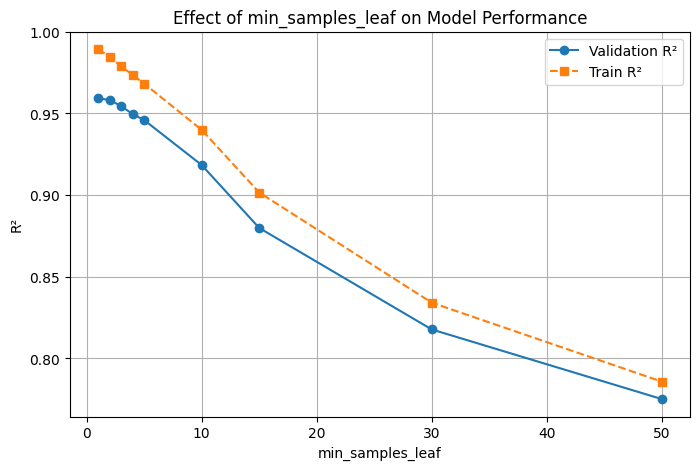

In [57]:
plt.figure(figsize=(8,5))
plt.plot(df_scores['min_samples_leaf'], df_scores['r2_val'], marker='o', label='Validation R²')
plt.plot(df_scores['min_samples_leaf'], df_scores['r2_train'], marker='s', linestyle='--', label='Train R²')
plt.xlabel('min_samples_leaf')
plt.ylabel('R²')
plt.title('Effect of min_samples_leaf on Model Performance')
plt.legend()
plt.grid(True)
plt.show()



**Insights:**

Since there is not much between train and validation R2,  overfitting is not a problem. 

## Results

In [58]:
max_depth = 20 
n_estimators = 20
min_samples_leaf = 3

dv, rf = rf_train(df_train, y_train_log, 
                      n_estimators=n_estimators, max_depth=max_depth, 
                      min_samples_leaf=min_samples_leaf)
    
# Predict on validation set
y_pred_val_log = rf_predict(df_val, dv, rf)
y_pred_val = np.expm1(y_pred_val_log)  # convert back to original units
    
# Evaluate metrics on val
rmse, mae, r2_val = regression_metrics(y_val, y_pred_val)
    
print(f"Validation RMSE:{rmse}")
print(f"Validation MAE:{mae}")
print(f"Validation R2:{r2_val}")
        
final_metrics.append(('Random Forest', rmse, mae, r2_val))

Validation RMSE:17272.68116283582
Validation MAE:8739.524476603994
Validation R2:0.9544206645500115


# XGBoost

In [59]:
# Train XGBoost


def xgb_train(df_train, df_val, y_train_log, y_val_log, eta=0.1, 
              num_boost_round=50, max_depth=3, min_child_weight=5):
    
    dicts_train = df_train.to_dict(orient='records')
    dicts_val = df_val.to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts_train)
    X_val = dv.transform(dicts_val)

    features = dv.get_feature_names_out().tolist()
    
    dtrain = xgb.DMatrix(X_train, label=y_train_log, feature_names=features)
    dval = xgb.DMatrix(X_val, label=y_val_log, feature_names=features)

    watchlist = [(dtrain, 'train'), (dval, 'val')]
    
    xgb_params = {
        'eta': eta,                     
        'max_depth': max_depth,                
        'min_child_weight': min_child_weight,         
        'objective': 'reg:squarederror',                        
        'eval_metric':['rmse', 'mae'],
        'nthreads':8,         
        'seed':1,            
        'verbosity':0  
    }
    
    
    evals_result = {}

    model = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        evals=watchlist,
        evals_result=evals_result,
        verbose_eval=False
    )

    # Predictions in log scale
    y_train_pred_log = model.predict(dtrain)
    y_val_pred_log = model.predict(dval)

    # Convert back to original scale
    y_train_pred = np.expm1(y_train_pred_log)
    y_val_pred = np.expm1(y_val_pred_log)

    # Compute metrics in original scale
    df_metrics = pd.DataFrame({
    'boost_round': range(num_boost_round),
    'train_rmse': evals_result['train']['rmse'],
    'val_rmse': evals_result['val']['rmse'],
    'train_mae': evals_result['train']['mae'],
    'val_mae': evals_result['val']['mae']
    })


    return dv, model, df_metrics

    

# Predict function
def xgb_predict(df, dv, model):
    dicts = df.to_dict(orient='records')
    X = dv.transform(dicts)

    features = dv.get_feature_names_out().tolist()
    
    d = xgb.DMatrix(X, feature_names=features)
    
    y_pred = model.predict(d)
    
    return y_pred

## Hyperparameter Tuning

### Choosing best `ETA` value

In [60]:
results = {}


for eta in [0.1, 0.3, 0.01, 0.05, 1]:
    dv, model, df_metrics = xgb_train(
        df_train, df_val, y_train_log, y_val_log,
        eta=eta, num_boost_round=200, max_depth=5, min_child_weight=10
    )
    
    # Predict (log scale → original scale)
    results[f'eta={eta}'] = df_metrics
    
    print(f"\n=== ETA: {eta} ===")
    print(df_metrics.head())


=== ETA: 0.1 ===
   boost_round  train_rmse  val_rmse  train_mae   val_mae
0            0    1.066027  1.049127   0.881574  0.869711
1            1    1.004167  0.987750   0.830817  0.818540
2            2    0.951142  0.935399   0.786593  0.774247
3            3    0.906766  0.891852   0.749807  0.738036
4            4    0.864497  0.850105   0.711362  0.700685

=== ETA: 0.3 ===
   boost_round  train_rmse  val_rmse  train_mae   val_mae
0            0    0.942560  0.927814   0.780175  0.768694
1            1    0.814130  0.802141   0.665554  0.656642
2            2    0.725284  0.718328   0.582623  0.578961
3            3    0.661777  0.658624   0.519729  0.519465
4            4    0.606928  0.606068   0.472893  0.475730

=== ETA: 0.01 ===
   boost_round  train_rmse  val_rmse  train_mae   val_mae
0            0    1.126077  1.108234   0.929091  0.917429
1            1    1.119357  1.101617   0.923825  0.912147
2            2    1.112730  1.095093   0.918617  0.906923
3            3   

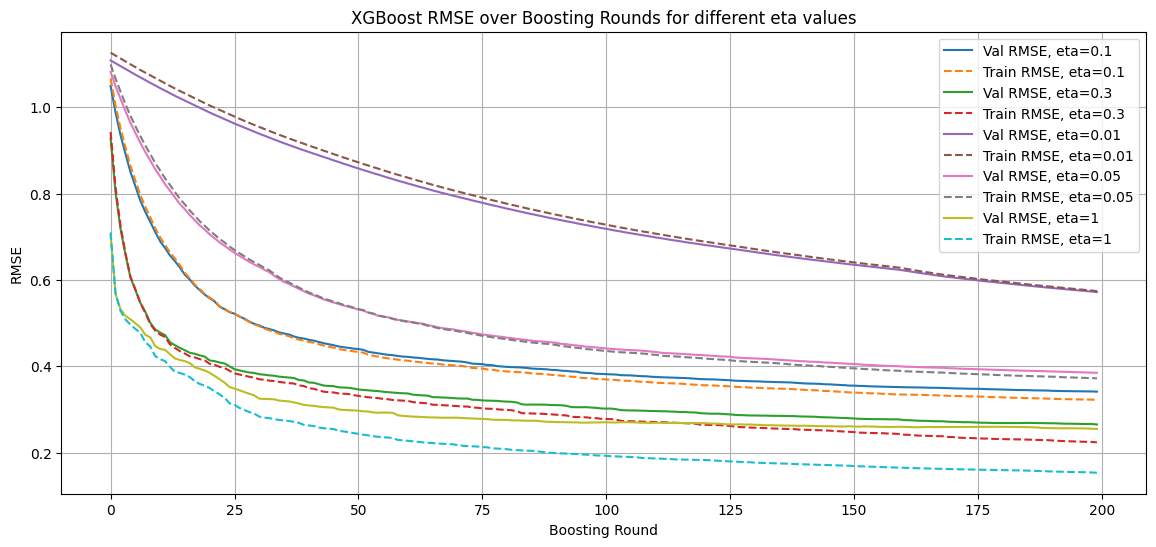

In [61]:
metrics = ['train_rmse', 'val_rmse', 'train_mae', 'val_mae']  # metrics to plot

plt.figure(figsize=(14, 6))

for eta, df in results.items():
    plt.plot(df['boost_round'], df['val_rmse'], label=f'Val RMSE, {eta}')
    plt.plot(df['boost_round'], df['train_rmse'], label=f'Train RMSE, {eta}', linestyle='--')

plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE over Boosting Rounds for different eta values')
plt.legend()
plt.grid(True)
plt.show()

**Insights:**

- `0.01, 0.05` - Low convergence, may need more boosting rounds for better performance
- `1.0` - RMSE drops very quickly at first and the gap between train and validation RMSE increases slightly. Risk of overfitting or unstable convergence is higher.
- `0.1, 0.3` - The RMSE curves drop faster, reaching lower RMSE much sooner. Validation RMSE and training RMSE are reasonably close, so overfitting is not severe.

**ETA = 0.1** seems to be well-balanced. 


### Choosing best `max_depth`

In [62]:
eta = 0.1
results = {}

for depth in range(1,11):
    dv, model, df_metrics = xgb_train(
        df_train, df_val, y_train_log, y_val_log,
        eta=eta, num_boost_round=200, max_depth=depth, min_child_weight=10
    )
    
    # Predict (log scale → original scale)
    results[f'max_depth={depth}'] = df_metrics

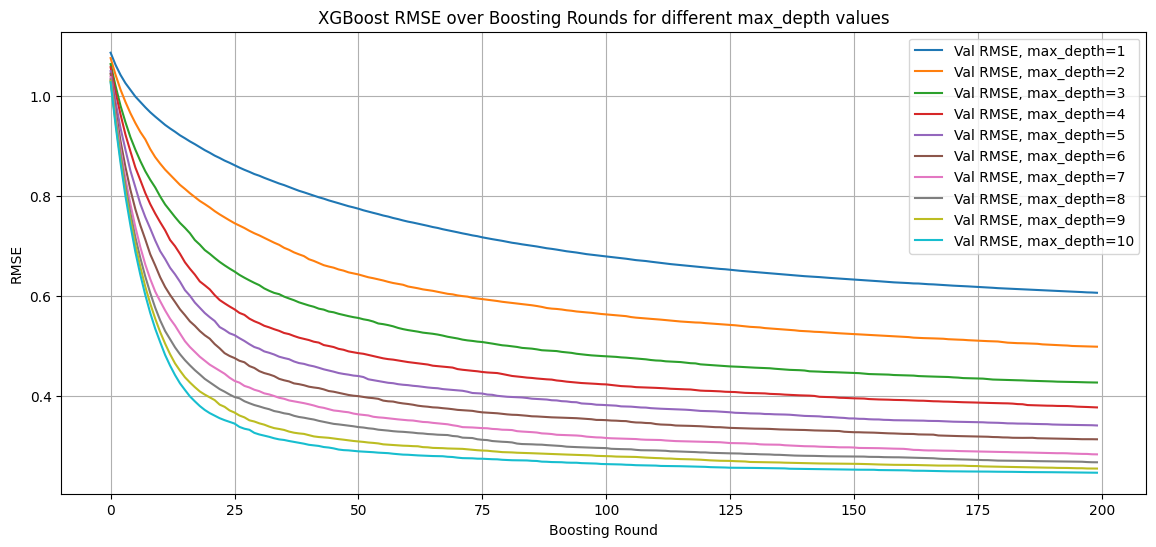

In [63]:
metrics = ['train_rmse', 'val_rmse', 'train_mae', 'val_mae']  # metrics to plot

plt.figure(figsize=(14, 6))

for max_depth, df in results.items():
    plt.plot(df['boost_round'], df['val_rmse'], label=f'Val RMSE, {max_depth}')

plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE over Boosting Rounds for different max_depth values')
plt.legend()
plt.grid(True)
plt.show()

**Insights:**

Below max_depth=5, the RMSE is still considerably higher.
    
The RMSE is low at max_depth = 6,7 and there's minimal change after. We can go with `max_depth=7`, as it seems to be the more optimal choice.  

### Choosing best `min_child_weight`

In [64]:
eta = 0.1
max_depth = 7
results = {}

for min_child_weight in [1,5,10,15,20,25,30]:
    dv, model, df_metrics = xgb_train(
        df_train, df_val, y_train_log, y_val_log,
        eta=eta, num_boost_round=200, max_depth=max_depth, min_child_weight=min_child_weight
    )
    
    # Predict (log scale → original scale)
    results[f'min_child_weight={min_child_weight}'] = df_metrics

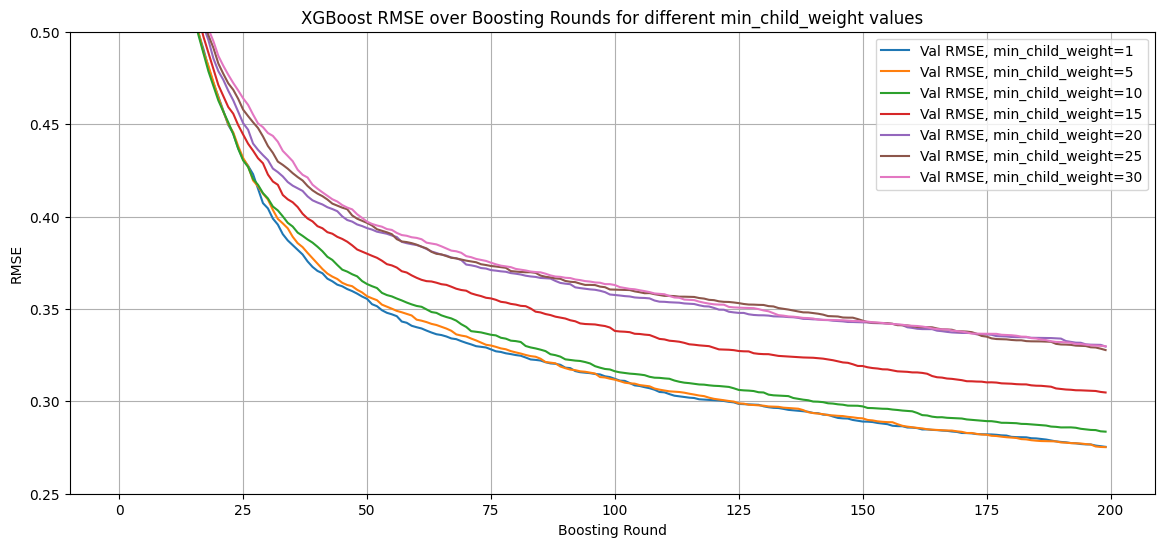

In [65]:
metrics = ['train_rmse', 'val_rmse', 'train_mae', 'val_mae']  # metrics to plot

plt.figure(figsize=(14, 6))

for min_child_weight, df in results.items():
    plt.plot(df['boost_round'], df['val_rmse'], label=f'Val RMSE, {min_child_weight}')

plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE over Boosting Rounds for different min_child_weight values')
plt.ylim(0.25,0.5)
plt.legend()
plt.grid(True)
plt.show()

**Insights:**

- min_child_weight > 20 have considerably higher RMSE's
- min_child_weight = 15 sits in the middle, but still inefficient in comparison to depth values <15
- min_child_weight = 1 and min_child_weight=5 have lower RMSE's.

The optimal choice in this case would be `min_child_weight = 5`

## Results

In [66]:
eta = 0.1
max_depth = 7
min_child_weight = 5 

dv, model, df_metrics = xgb_train(
    df_train, df_val, y_train_log, y_val_log,
    eta=eta, num_boost_round=200, max_depth=max_depth, min_child_weight=min_child_weight
)

y_val_pred_log = xgb_predict(df_val, dv, model)
y_val_pred = np.expm1(y_val_pred_log)

rmse,  mae, r2 = regression_metrics(y_val, y_val_pred)

print(f"Validation RMSE: {rmse}")
print(f"Validation MAE: {mae}")
print(f"Validation R2: {r2}")

final_metrics.append(('XGBoost', rmse, mae, r2))

Validation RMSE: 20827.276730288097
Validation MAE: 11340.8203125
Validation R2: 0.9337305426597595


In [67]:
df_final=pd.DataFrame(final_metrics, columns = ['Model', 'Val RMSE', 'Val MAE', 'VAL R2'])

df_final_indexed = df_final.set_index('Model')

# Apply simple background gradients
styled = (df_final_indexed.style
          .background_gradient(subset=['Val RMSE', 'Val MAE'], cmap='RdYlGn_r')  # lower = green
          .background_gradient(subset=['VAL R2'], cmap='RdYlGn')                  # higher = green
          .format('{:.3f}'))

styled

,Val RMSE,Val MAE,VAL R2
Model,,,
Linear Regression,37364.657,21836.710,0.787
Random Forest,17272.681,8739.524,0.954
XGBoost,20827.277,11340.820,0.934


## Training df_full_train

In [68]:
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = df_full_train['yield_hg_ha'].values
y_full_train_log = np.log1p(y_full_train)

In [69]:
del df_full_train['yield_hg_ha']

In [70]:
# Log-transform highly skewed numerical features
skewed_features = ['pesticide_tonnes', 'average_rain_fall_mm_per_year']
for col in skewed_features:
    df_full_train[col] = np.log1p(df_full_train[col])

df_full_train[numerical] = scaler.fit_transform(df_full_train[numerical])

In [72]:
max_depth = 20 
n_estimators = 20
min_samples_leaf = 3

dv, rf = rf_train(df_full_train, y_full_train_log, 
                      n_estimators=n_estimators, max_depth=max_depth, 
                      min_samples_leaf=min_samples_leaf)
    
# Predict on test set
y_pred_test_log = rf_predict(df_test, dv, rf)
y_pred_test = np.expm1(y_pred_test_log)  # convert back to original units
    
# Evaluate metrics on test
rmse, mae, r2 = regression_metrics(y_test, y_pred_test)
    
print(f"Test RMSE:{rmse}")
print(f"Test MAE:{mae}")
print(f"Test R2:{r2}")


Test RMSE:18179.947583268993
Test MAE:8559.523177759489
Test R2:0.9510846529273412
